# Train Gesture Recognition Model for ESP32

This notebook trains a lightweight CNN model for rock-paper-scissors gesture recognition on ESP32.
The model is optimized for embedded systems with limited RAM and processing power.

## 1. Import Required Libraries

In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.onnx
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import os

## 2. Data Preparation

Why? The ESP32 has very limited RAM (KB, not GB). We must shrink data immediately.

In [ ]:
# Check if dataset exists
import os
if not os.path.exists('./data'):
    print("❌ ERROR: 'data' folder not found!")
    print("Make sure you have the data folder in the current directory with subfolders: rock, paper, scissors")
    raise FileNotFoundError("Dataset folder missing. Please check the path.")

# Load data
try:
    full_dataset = datasets.ImageFolder(root='./data', transform=None)
except Exception as e:
    print(f"❌ Error loading data: {e}")
    raise

# Dynamic Class Detection
NUM_CLASSES = len(full_dataset.classes)
print(f"✅ Dataset loaded: {len(full_dataset)} images")
print(f"Classes: {full_dataset.classes}")
print(f"Number of classes: {NUM_CLASSES}")

✅ Dataset loaded: 3075 images
Classes: ['paper', 'rock', 'scissors']
Number of classes: 3


In [40]:
# Split data with stratification to ensure all classes in each split
from sklearn.model_selection import train_test_split

# Get all indices and labels
all_indices = np.arange(len(full_dataset))
all_labels = np.array([full_dataset.targets[i] for i in range(len(full_dataset))])

# First split: 80% train, 20% temp (val+test)
train_idx, temp_idx, train_labels, temp_labels = train_test_split(
    all_indices, all_labels, test_size=0.2, random_state=42, stratify=all_labels
)

# Second split: split temp into 50% val, 50% test (to get 10% each)
val_idx, test_idx, val_labels, test_labels = train_test_split(
    temp_idx, temp_labels, test_size=0.5, random_state=42, stratify=temp_labels
)

# Create subsets using indices
train_data = torch.utils.data.Subset(full_dataset, train_idx)
val_data = torch.utils.data.Subset(full_dataset, val_idx)
test_data = torch.utils.data.Subset(full_dataset, test_idx)

print(f"Train set: {len(train_data)} images (80%)")
print(f"  Class distribution: {np.bincount(train_labels)}")
print(f"Validation set: {len(val_data)} images (10%)")
print(f"  Class distribution: {np.bincount(val_labels)}")
print(f"Test set: {len(test_data)} images (10%)")
print(f"  Class distribution: {np.bincount(test_labels)}")

Train set: 2460 images (80%)
  Class distribution: [812 829 819]
Validation set: 307 images (10%)
  Class distribution: [102 103 102]
Test set: 308 images (10%)
  Class distribution: [101 104 103]


In [41]:
# Define data augmentation transforms for training (applied to PIL images BEFORE ToTensor)
from torchvision.transforms import RandomRotation, RandomAffine, ColorJitter, RandomPerspective

# Augmentation transform - applied to raw PIL images
transform_train = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((96, 96)),
    RandomRotation(degrees=10),                    # Rotation range
    RandomAffine(degrees=0, translate=(0.1, 0.1)), # Width/height shift
    ColorJitter(brightness=(0.7, 1.3)),           # Brightness range
    RandomPerspective(distortion_scale=0.1),      # Zoom effect simulation
    transforms.ToTensor(),
])

# No augmentation for validation/test (just normalize)
transform_val_test = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((96, 96)),
    transforms.ToTensor(),
])

# Create custom dataset subsets with proper transforms
class SubsetWithTransform(torch.utils.data.Dataset):
    def __init__(self, dataset, indices, transform=None):
        self.dataset = dataset
        self.indices = indices
        self.transform = transform
    
    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, idx):
        # Get raw PIL image and label from original dataset
        img, label = self.dataset[self.indices[idx]]
        # Apply transform to PIL image
        if self.transform:
            img = self.transform(img)
        return img, label

# Create dataset subsets with appropriate transforms
train_subset = SubsetWithTransform(full_dataset, train_idx, transform=transform_train)
val_subset = SubsetWithTransform(full_dataset, val_idx, transform=transform_val_test)
test_subset = SubsetWithTransform(full_dataset, test_idx, transform=transform_val_test)

# Create Data Loaders
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_subset, batch_size=32, shuffle=False)

print(f"Data loaders created with augmentation")
print(f"Train batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Data loaders created with augmentation
Train batches: 77
Validation batches: 10
Test batches: 10


## 3. Model Architecture (TinyCNN)

Why? We need a balance between "Smart" (Deep) and "Fast/Light" (Shallow) for ESP32.

In [42]:
class TinyCNN(nn.Module):
    def __init__(self):
        super(TinyCNN, self).__init__()
        
        # --- Feature Extraction (The "Eyes") ---
        # We use Convolutional layers to detect edges, textures, and shapes.
        # MaxPool layers reduce the image size by half to reduce calculation cost.
        
        # Block 1: Input (1x96x96) -> Detects simple edges
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, padding=1), # 8 filters scan the image
            nn.ReLU(),                                 # Activation: Removes negative numbers (noise)
            nn.MaxPool2d(2, 2)                         # Downsample: 96x96 -> 48x48
        )
        
        # Block 2: Input (8x48x48) -> Detects shapes/curves
        self.layer2 = nn.Sequential(
            nn.Conv2d(8, 16, kernel_size=3, padding=1), # 16 filters combine edges
            nn.ReLU(),
            nn.MaxPool2d(2, 2)                          # Downsample: 48x48 -> 24x24
        )

        # Block 3: Input (16x24x24) -> Detects complex objects
        self.layer3 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1), # 32 filters combine shapes
            nn.ReLU(),
            nn.MaxPool2d(2, 2)                           # Downsample: 24x24 -> 12x12
        )

        # --- Classification (The "Brain") ---
        # Flatten: Converts the 3D feature map (32 channels x 12 width x 12 height) 
        # into a 1D array (4608 numbers) so the dense layers can make a decision.
        self.flatten = nn.Flatten()
        
        # Fully Connected Layer: Compresses 4608 features into 64 logic neurons
        self.fc1 = nn.Linear(32 * 12 * 12, 64) 
        self.relu = nn.ReLU()
        
        # Output Layer: Compresses 64 neurons into [NUM_CLASSES] probabilities
        self.fc2 = nn.Linear(64, NUM_CLASSES) 

    def forward(self, x):
        # Defines the flow of data through the network
        x = self.layer3(self.layer2(self.layer1(x))) # Run through Conv blocks
        x = self.flatten(x)                          # Flatten to 1D
        x = self.fc2(self.relu(self.fc1(x)))         # Run through Dense blocks
        return x

print("TinyCNN model architecture defined")

TinyCNN model architecture defined


In [43]:
# Initialize Model and Hardware
# 'cuda': Uses NVIDIA GPU if available (much faster). 'cpu': Fallback.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TinyCNN().to(device)

print(f"Model initialized on device: {device}")
print(f"Model architecture:")
print(model)

Model initialized on device: cpu
Model architecture:
TinyCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=4608, out_features=64, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=64, out_features=3, bias=True)
)


## 4. Setup Training Configuration

In [44]:
# Criterion (Loss Function): 'CrossEntropy' is the standard math for multi-class classification.
criterion = nn.CrossEntropyLoss()

# Optimizer: 'Adam' is an algorithm that adjusts the learning rate automatically.
optimizer = optim.Adam(model.parameters(), lr=0.001)

EPOCHS = 10

print(f"Training configuration:")
print(f"  Loss function: CrossEntropyLoss")
print(f"  Optimizer: Adam (lr=0.001)")
print(f"  Epochs: {EPOCHS}")

Training configuration:
  Loss function: CrossEntropyLoss
  Optimizer: Adam (lr=0.001)
  Epochs: 10


## 5. Training Loop

Why? This process adjusts the random weights inside the model to minimize error.

In [45]:
# Storage for tracking metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
test_accuracies = []

# For confusion matrix (only final epoch)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
all_train_preds = []
all_train_labels = []
all_val_preds = []
all_val_labels = []
all_test_preds = []
all_test_labels = []

print(f"Training on {device} with {NUM_CLASSES} classes...\n")

for epoch in range(EPOCHS):
    # --- TRAIN STEP ---
    model.train()
    total_loss = 0
    correct_train = 0
    total_train = 0
    train_preds_epoch = []
    train_labels_epoch = []
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        
        train_preds_epoch.extend(predicted.cpu().numpy())
        train_labels_epoch.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(train_loader)
    train_acc = 100 * correct_train / total_train
    train_losses.append(avg_loss)
    train_accuracies.append(train_acc)
    
    # Only store final epoch predictions for confusion matrix
    if epoch == EPOCHS - 1:
        all_train_preds = train_preds_epoch
        all_train_labels = train_labels_epoch

    # --- VALIDATION STEP ---
    model.eval()
    correct_val = 0
    total_val = 0
    val_loss = 0
    val_preds_epoch = []
    val_labels_epoch = []
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
            
            val_preds_epoch.extend(predicted.cpu().numpy())
            val_labels_epoch.extend(labels.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    val_acc = 100 * correct_val / total_val
    val_accuracies.append(val_acc)
    
    # Only store final epoch predictions for confusion matrix
    if epoch == EPOCHS - 1:
        all_val_preds = val_preds_epoch
        all_val_labels = val_labels_epoch

    # --- TEST STEP ---
    correct_test = 0
    total_test = 0
    test_preds_epoch = []
    test_labels_epoch = []
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
            
            test_preds_epoch.extend(predicted.cpu().numpy())
            test_labels_epoch.extend(labels.cpu().numpy())

    test_acc = 100 * correct_test / total_test
    test_accuracies.append(test_acc)
    
    # Only store final epoch predictions for confusion matrix
    if epoch == EPOCHS - 1:
        all_test_preds = test_preds_epoch
        all_test_labels = test_labels_epoch

    print(f"Epoch [{epoch+1}/{EPOCHS}] | Train Loss: {avg_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Train: {train_acc:.2f}% | Val: {val_acc:.2f}% | Test: {test_acc:.2f}%")

print("\n✅ Training completed!")

Training on cpu with 3 classes...

Epoch [1/10] | Train Loss: 0.9855 | Val Loss: 0.5849 | Train: 48.09% | Val: 79.48% | Test: 79.55%
Epoch [2/10] | Train Loss: 0.7130 | Val Loss: 0.3843 | Train: 72.80% | Val: 88.27% | Test: 86.36%
Epoch [3/10] | Train Loss: 0.5012 | Val Loss: 0.2492 | Train: 80.28% | Val: 93.81% | Test: 88.31%
Epoch [4/10] | Train Loss: 0.3361 | Val Loss: 0.1762 | Train: 88.25% | Val: 93.81% | Test: 92.21%
Epoch [5/10] | Train Loss: 0.2789 | Val Loss: 0.0882 | Train: 90.24% | Val: 97.39% | Test: 96.43%
Epoch [6/10] | Train Loss: 0.2048 | Val Loss: 0.1079 | Train: 93.21% | Val: 95.77% | Test: 96.43%
Epoch [7/10] | Train Loss: 0.1709 | Val Loss: 0.0523 | Train: 94.27% | Val: 98.05% | Test: 97.40%
Epoch [8/10] | Train Loss: 0.1244 | Val Loss: 0.0526 | Train: 96.22% | Val: 97.39% | Test: 96.75%
Epoch [9/10] | Train Loss: 0.1297 | Val Loss: 0.0296 | Train: 95.33% | Val: 100.00% | Test: 99.03%
Epoch [10/10] | Train Loss: 0.1170 | Val Loss: 0.0197 | Train: 96.50% | Val: 100.0

## 6. Plot Training Metrics

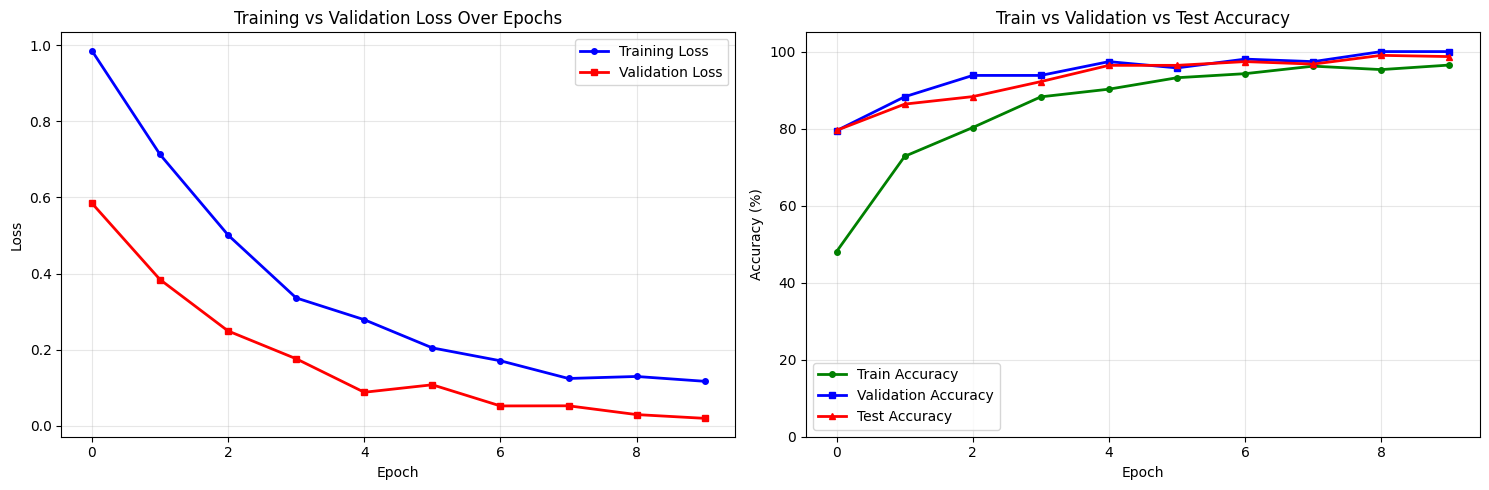


Final Results:
  Final Training Loss: 0.1170
  Final Validation Loss: 0.0197
  Final Training Accuracy: 96.50%
  Final Validation Accuracy: 100.00%
  Final Test Accuracy: 98.70%


In [46]:
# Plot loss and accuracy with validation
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot - Training vs Validation Loss
axes[0].plot(train_losses, 'b-', label='Training Loss', linewidth=2, marker='o', markersize=4)
axes[0].plot(val_losses, 'r-', label='Validation Loss', linewidth=2, marker='s', markersize=4)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training vs Validation Loss Over Epochs')
axes[0].grid(True, alpha=0.3)
axes[0].legend()

# Accuracy plot with Train/Val/Test
axes[1].plot(train_accuracies, 'g-', label='Train Accuracy', linewidth=2, marker='o', markersize=4)
axes[1].plot(val_accuracies, 'b-', label='Validation Accuracy', linewidth=2, marker='s', markersize=4)
axes[1].plot(test_accuracies, 'r-', label='Test Accuracy', linewidth=2, marker='^', markersize=4)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Train vs Validation vs Test Accuracy')
axes[1].set_ylim([0, 105])
axes[1].grid(True, alpha=0.3)
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"\nFinal Results:")
print(f"  Final Training Loss: {train_losses[-1]:.4f}")
print(f"  Final Validation Loss: {val_losses[-1]:.4f}")
print(f"  Final Training Accuracy: {train_accuracies[-1]:.2f}%")
print(f"  Final Validation Accuracy: {val_accuracies[-1]:.2f}%")
print(f"  Final Test Accuracy: {test_accuracies[-1]:.2f}%")

Validation predictions: 307 predictions
Unique classes in val_preds: [0 1 2]
Unique classes in val_labels: [0 1 2]
Val pred distribution: [102 103 102]
Val label distribution: [102 103 102]

Test predictions: 308 predictions
Unique classes in test_preds: [0 1 2]
Unique classes in test_labels: [0 1 2]
Test pred distribution: [ 97 108 103]
Test label distribution: [101 104 103]


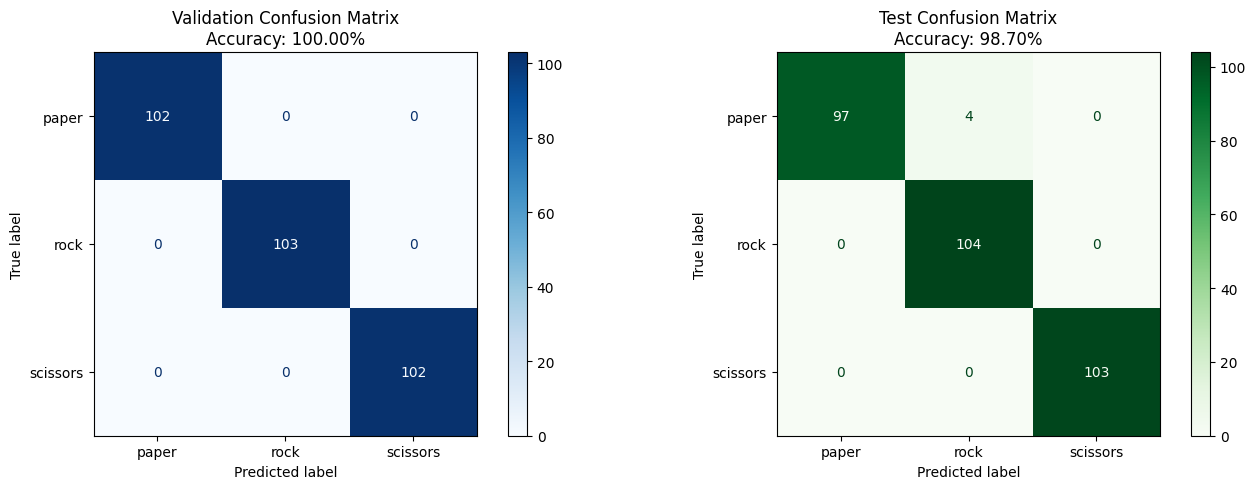


✅ Confusion matrices generated!


In [47]:
# Generate and plot confusion matrices
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

print(f"Validation predictions: {len(all_val_preds)} predictions")
print(f"Unique classes in val_preds: {np.unique(all_val_preds)}")
print(f"Unique classes in val_labels: {np.unique(all_val_labels)}")
print(f"Val pred distribution: {np.bincount(all_val_preds)}")
print(f"Val label distribution: {np.bincount(all_val_labels)}")

print(f"\nTest predictions: {len(all_test_preds)} predictions")
print(f"Unique classes in test_preds: {np.unique(all_test_preds)}")
print(f"Unique classes in test_labels: {np.unique(all_test_labels)}")
print(f"Test pred distribution: {np.bincount(all_test_preds)}")
print(f"Test label distribution: {np.bincount(all_test_labels)}")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Validation Confusion Matrix
val_cm = confusion_matrix(all_val_labels, all_val_preds)
disp_val = ConfusionMatrixDisplay(confusion_matrix=val_cm, display_labels=full_dataset.classes)
disp_val.plot(ax=axes[0], cmap='Blues', values_format='d')
axes[0].set_title(f'Validation Confusion Matrix\nAccuracy: {val_accuracies[-1]:.2f}%')

# Test Confusion Matrix
test_cm = confusion_matrix(all_test_labels, all_test_preds)
disp_test = ConfusionMatrixDisplay(confusion_matrix=test_cm, display_labels=full_dataset.classes)
disp_test.plot(ax=axes[1], cmap='Greens', values_format='d')
axes[1].set_title(f'Test Confusion Matrix\nAccuracy: {test_accuracies[-1]:.2f}%')

plt.tight_layout()
plt.show()

print(f"\n✅ Confusion matrices generated!")


## 7. Save Trained Model (PyTorch Format)

## 7. Classification Report (Precision, Recall, F1-Score)


In [48]:
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score
import pandas as pd

print("=" * 80)
print("TEST SET - CLASSIFICATION REPORT")
print("=" * 80)

test_report = classification_report(
    all_test_labels, all_test_preds,
    target_names=full_dataset.classes,
    digits=4
)
print(test_report)

# Create a detailed table for test
test_metrics = classification_report(
    all_test_labels, all_test_preds,
    target_names=full_dataset.classes,
    output_dict=True
)

test_df = pd.DataFrame(test_metrics).transpose()
print("\nTest Set - Detailed Metrics Table:")
print(test_df.to_string())

# Summary statistics
print("\n" + "=" * 80)
print("TEST SET SUMMARY")
print("=" * 80)
print(f"Accuracy: {test_metrics['accuracy']:.4f} ({test_metrics['accuracy']*100:.2f}%)")
print(f"Macro Average F1-Score: {test_metrics['macro avg']['f1-score']:.4f}")
print(f"Weighted Average F1-Score: {test_metrics['weighted avg']['f1-score']:.4f}")



TEST SET - CLASSIFICATION REPORT
              precision    recall  f1-score   support

       paper     1.0000    0.9604    0.9798       101
        rock     0.9630    1.0000    0.9811       104
    scissors     1.0000    1.0000    1.0000       103

    accuracy                         0.9870       308
   macro avg     0.9877    0.9868    0.9870       308
weighted avg     0.9875    0.9870    0.9870       308


Test Set - Detailed Metrics Table:
              precision    recall  f1-score     support
paper          1.000000  0.960396  0.979798  101.000000
rock           0.962963  1.000000  0.981132  104.000000
scissors       1.000000  1.000000  1.000000  103.000000
accuracy       0.987013  0.987013  0.987013    0.987013
macro avg      0.987654  0.986799  0.986977  308.000000
weighted avg   0.987494  0.987013  0.987004  308.000000

TEST SET SUMMARY
Accuracy: 0.9870 (98.70%)
Macro Average F1-Score: 0.9870
Weighted Average F1-Score: 0.9870


In [ ]:
# Save the trained model
torch.save(model.state_dict(), 'trained_models/esp32_gesture_model.pth')
print("Model saved as 'trained_models/esp32_gesture_model.pth'")

✅ Model saved as 'trained_models/esp32_gesture_model.pth'


## 8. Export to ONNX

Why? PyTorch (.pth) files are for Python. ESP32 needs TensorFlow Lite. 
ONNX is the "bridge" format to convert PyTorch → ONNX → TensorFlow.

In [ ]:
# Create models directory if it doesn't exist
os.makedirs('trained_models', exist_ok=True)

print("Exporting to ONNX...")

# Create a dummy input tensor with the exact shape of data to expect (1 channel, 96x96).
dummy_input = torch.randn(1, 1, 96, 96, device=device)

torch.onnx.export(
    model, 
    dummy_input, 
    "trained_models/esp32_model.onnx",
    verbose=False,
    input_names=['input'],   # Crucial naming for the ESP32 code to find the input tensor
    output_names=['output'], # Crucial naming for the ESP32 code to find the output tensor
    opset_version=11
)

print("Done! File saved as 'trained_models/esp32_model.onnx'")
print("\nNext steps:")
print("1. Run 3_OnnxToTf.py to convert ONNX → TensorFlow")
print("2. Run 4_TFtofloat32.py to optimize for ESP32")
print("3. Run 5_TftoArrayquantized.py to quantize the model")

Exporting to ONNX...
============== Diagnostic Run torch.onnx.export version 2.0.0+cpu ==============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

✅ Done! File saved as 'trained_models/esp32_model.onnx'

Next steps:
1. Run 3_OnnxToTf.py to convert ONNX → TensorFlow
2. Run 4_TFtofloat32.py to optimize for ESP32
3. Run 5_TftoArrayquantized.py to quantize the model
